### Moive Recommendation
In this notebook, I will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

In [2]:
#import packages
import findspark
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType
from pyspark.sql import Row
from csv import reader
from pyspark.ml.evaluation import RegressionEvaluator
#ALS model
from pyspark.mllib.recommendation import ALS

In [3]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

## Part1: Data ETL and Data Exploration

In [5]:
spark = (
    SparkSession.builder
        .master("local[*]")
        .appName("Spark Movie Recommendation Project")
        .getOrCreate()
)
sc = spark.sparkContext

In [6]:
movies = spark.read.load(".../movies.csv", format='csv', header = True)
ratings = spark.read.load(".../ratings.csv", format='csv', header = True)
links = spark.read.load(".../links.csv", format='csv', header = True)
tags = spark.read.load(".../tags.csv", format='csv', header = True)

In [11]:
print('Distinct values of ratings:')
print ",".join(sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0

In [12]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1

In [13]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3063 out of 9066 movies are rated by only one user

# The number of Users

In [15]:
print('The number of Users from the Ratings dataset:')
print (ratings.drop_duplicates(subset=['userId']).count())

The number of Users from the Ratings dataset:
671

# The number of Movies

In [17]:
print('The number of Movies from the Movies dataset:')
print (movies.drop_duplicates(subset=['movieId']).count())

The number of Movies from the Movies dataset:
9125

# List movies not rated before

In [19]:
print('The number of Movies are Rated by Users from the Ratings dataset:')
print (ratings.drop_duplicates(subset=['movieId']).count())

The number of Movies are Rated by Users from the Ratings dataset:
9066

In [20]:
print('The number of Movies are not Rated by Users from the Ratings dataset:')
print (movies.drop_duplicates(subset=['movieId']).count() - ratings.drop_duplicates(subset=['movieId']).count())

The number of Movies are not Rated by Users from the Ratings dataset:
59

In [21]:
%sql
CREATE TEMPORARY TABLE movies_
  USING csv
  OPTIONS (path "/FileStore/tables/movies.csv", header "true")

In [22]:
%sql
CREATE TEMPORARY TABLE rates_
  USING csv
  OPTIONS (path "/FileStore/tables/ratings.csv", header "true")

In [23]:
%sql
SELECT title
FROM movies_ m
WHERE m.movieId NOT IN (SELECT movieId FROM rates_)
group by title

title
Welcome to Me (2014)
"Story of O, The (Histoire d'O) (1975)"
Grandma (2015)
"Immigrant, The (2013)"
The Neon Demon (2016)
Nerve (2016)
Pickup on South Street (1953)
You Only Live Once (1937)
Berserk (1967)
February (2015)


## Part2: Spark ALS based approach for training model
I will use an RDD-based API from [pyspark.mllib](https://spark.apache.org/docs/2.1.1/mllib-collaborative-filtering.html) to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

### ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [31]:
movie_rating = sc.textFile("/FileStore/tables/ratings.csv")

In [32]:
#data preparation:
head = movie_rating.take(1)[0]
rating_data = movie_rating.filter(lambda x: x!= head).map(lambda x: x.split(',')).map(lambda tokens: (tokens[0], tokens[1], tokens[2])).cache()

Now I split the data into training/validation/testing sets using a 6/2/2 ratio.

In [33]:
#data split: Now I split the data into training/validation/testing sets using a 6/2/2 ratio.
train, cv, test = rating_data.randomSplit([6,2,2], seed = 7856)

In [34]:
train_pre = train.map(lambda x: (x[0], x[1]))
cv_pre = cv.map(lambda x: (x[0], x[1]))
test_pre = test.map(lambda x: (x[0], x[1]))

In [35]:
#cache() will cache the RDD into memory
#It is one mechanism to speed up applications that access the same RDD multiple times.
train.cache()
train_pre.cache()
cv.cache()
cv_pre.cache()
test.cache()
test_pre.cache()

Out[ 13 ]: PythonRDD[167] at RDD at PythonRDD.scala:51

### Model testing
And finally, make a prediction and check the testing error.

In [37]:
def train_ALS(train, cv, train_pre, cv_pre, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    #err = 0
    err = []
    train_err = []
    for rank in ranks:
        for reg in reg_param:
            # write your approach to train ALS model
            # Build the recommendation model using ALS on the training data
            # Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
            model = ALS.train(train, rank, iterations=num_iters,lambda_=reg)
            # get the rating result:
            train_predictions = model.predictAll(train_pre).map(lambda x: ((x[0], x[1]), x[2]))
            train_rap = train.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(train_predictions)
            train_error = math.sqrt(train_rap.map(lambda x: (x[1][0] - x[1][1])**2).mean())
            train_err.append(train_error)
            #cv:
            predictions = model.predictAll(cv_pre).map(lambda x: ((x[0], x[1]), x[2]))
            rates_and_preds = cv.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(predictions)
            # get the RMSE
            error = math.sqrt(rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean())
            err.append(error)
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    cv_prediction = best_model.predictAll(cv_pre).map(lambda x: ((x[0], x[1]), x[2]))
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model, best_rank, best_regularization, min_error, err, train_err


In [38]:
num_iterations = 10
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

In [39]:
import time
start_time = time.time()
final_model, best_tank, best_regularization, min_error, err, train_err = train_ALS(train = train, cv = cv,  train_pre = train_pre, cv_pre = cv_pre, num_iters = num_iterations, reg_param = reg_params, ranks = ranks)

6 latent factors and regularization = 0.05: validation RMSE is 1.02417401443
6 latent factors and regularization = 0.1: validation RMSE is 0.958616940906
6 latent factors and regularization = 0.2: validation RMSE is 0.936749265672
6 latent factors and regularization = 0.4: validation RMSE is 0.997803677721
6 latent factors and regularization = 0.8: validation RMSE is 1.21439057968
8 latent factors and regularization = 0.05: validation RMSE is 1.04022931292
8 latent factors and regularization = 0.1: validation RMSE is 0.959433400495
8 latent factors and regularization = 0.2: validation RMSE is 0.937475046334
8 latent factors and regularization = 0.4: validation RMSE is 0.99850455709
8 latent factors and regularization = 0.8: validation RMSE is 1.21438875741
10 latent factors and regularization = 0.05: validation RMSE is 1.04746200782
10 latent factors and regularization = 0.1: validation RMSE is 0.954764539074
10 latent factors and regularization = 0.2: validation RMSE is 0.937035224493
10 latent factors and regularization = 0.4: validation RMSE is 0.997950790683
10 latent factors and regularization = 0.8: validation RMSE is 1.21439191237
12 latent factors and regularization = 0.05: validation RMSE is 1.05241599787
12 latent factors and regularization = 0.1: validation RMSE is 0.957584931332
12 latent factors and regularization = 0.2: validation RMSE is 0.93641504817
12 latent factors and regularization = 0.4: validation RMSE is 0.998798846102
12 latent factors and regularization = 0.8: validation RMSE is 1.21439349013
14 latent factors and regularization = 0.05: validation RMSE is 1.05728116196
14 latent factors and regularization = 0.1: validation RMSE is 0.961514394923
14 latent factors and regularization = 0.2: validation RMSE is 0.935113784429
14 latent factors and regularization = 0.4: validation RMSE is 0.998425043359
14 latent factors and regularization = 0.8: validation RMSE is 1.21438790155

The best model has 14 latent factors and regularization = 0.2

In [40]:
print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

Total Runtime: 457.32 seconds

In [42]:
#recommend movies for users:
final_model.recommendProductsForUsers(10).take(1)

Out[ 20 ]: 
[(512,
 (Rating(user=512, product=67504, rating=5.404407277292453),
 Rating(user=512, product=83411, rating=5.404407277292453),
 Rating(user=512, product=83318, rating=5.404407277292453),
 Rating(user=512, product=76173, rating=5.14732936810112),
 Rating(user=512, product=31435, rating=5.14732936810112),
 Rating(user=512, product=59684, rating=5.14732936810112),
 Rating(user=512, product=7669, rating=5.002620500730329),
 Rating(user=512, product=5490, rating=4.915614423925212),
 Rating(user=512, product=106438, rating=4.8879094522387545),
 Rating(user=512, product=8955, rating=4.87451818664419)))]

In [43]:
#test the selected model:
test_model = final_model.predictAll(test_pre).map(lambda x: ((x[0], x[1]), x[2]))
test_rates_and_preds = test.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(test_model)
test_error = math.sqrt(test_rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean())

In [44]:
print ('For testing data the RMSE is %s' % (test_error))

For testing data the RMSE is 0.909215619274

In [45]:
iter_array = [x for x in range(1, 26)]

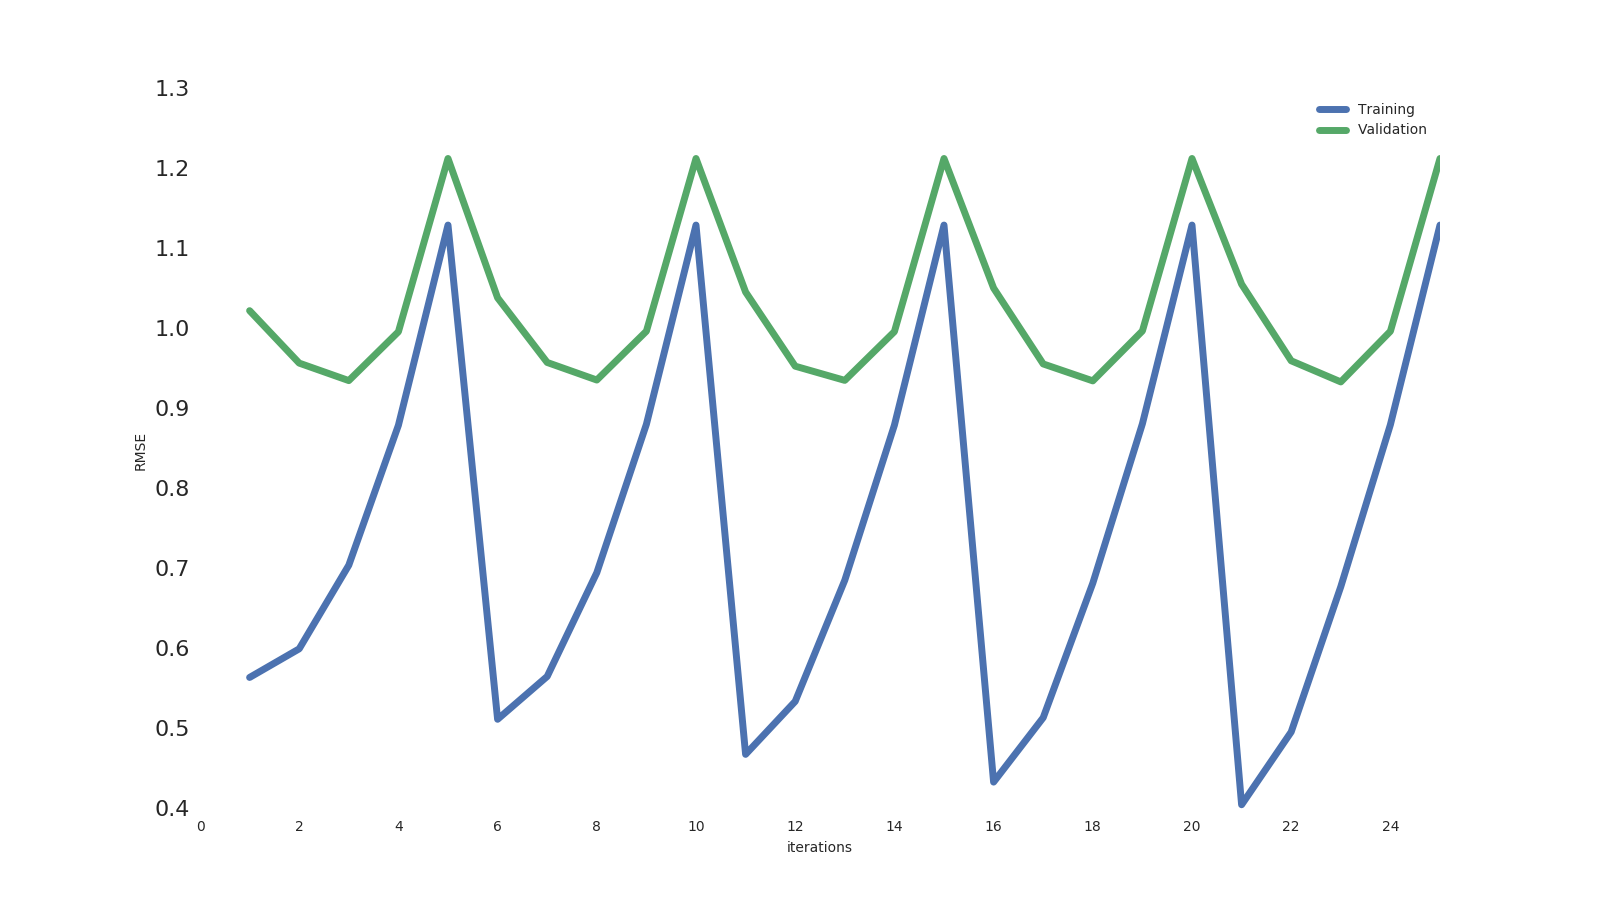

In [46]:
plt.cla()
#plot learning curve
plt.figure(figsize=(16, 9))
plt.plot(iter_array, train_err, label='Training', linewidth=5)
plt.plot(iter_array, err, label='Validation', linewidth=5)
plt.xticks(range(0, max(iter_array) + 1, 2), fontsize=10)
plt.yticks(fontsize=16)
plt.xlabel('iterations', fontsize=10)
plt.ylabel('RMSE', fontsize=10)
plt.legend(loc='best', fontsize=10) 
plt.show()
display()